In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display

In [3]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data   = data[:,1:]

In [5]:
dataT   = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()

train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
def create_net():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784, 64)

      self.fc1 = nn.Linear(64, 32)
      self.fc2 = nn.Linear(32,32)

      self.output = nn.Linear(32,10)

    def forward(self, x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.output(x)

  net = mnistNet()
  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=.01)

  return net, loss_fun, optimizer

In [12]:
epochs = 60

def train_model():

  net, loss_fun, optimizer = create_net()

  losses    = torch.zeros((epochs,2))
  train_acc  = []
  test_acc   = []

  for i in range(epochs):
    batch_acc  = []
    batch_loss = []
    for X,y in train_loader:

      y_hat = net(X)
      loss = loss_fun(y_hat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_loss.append(loss.item())

      matches = torch.argmax(y_hat,axis=1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100*torch.mean(matches_numeric)
      batch_acc.append( accuracy_pct )

    train_acc.append(np.mean(batch_acc))

    losses[i,0] = np.mean(batch_loss)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      y_hat = net(X)

    test_acc.append( 100*torch.mean((torch.argmax(y_hat,axis=1)==y).float()) )
    loss = loss_fun(y_hat,y)
    losses[i,1] = loss.item()

  return train_acc, test_acc, losses, net


In [13]:
train_acc, test_acc, losses, net = train_model()


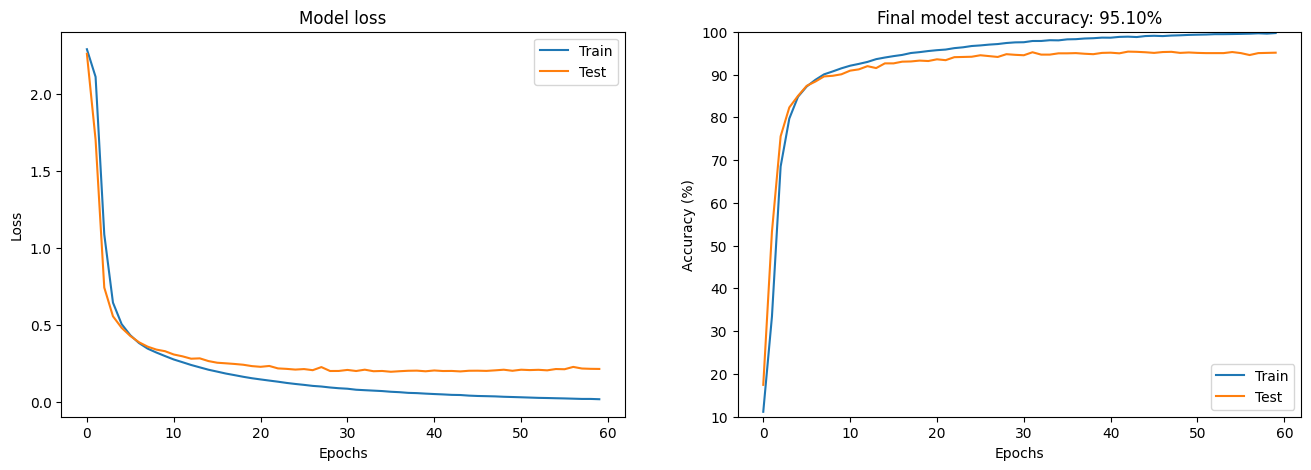

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train','Test'])
ax[0].set_title('Model loss')

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()